<a href="https://www.kaggle.com/code/kbdharun/cyclone-cyclegan?scriptVersionId=165650652" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Cycle GAN Implementation on Cyclone Dataset

# Objectives

- To implement a Generative Adversarial Network based approach to generate high resolution passive microwave rainfall images from satellite infrared images.

- To compare the performance of proposed model with existing models.

- To investigate and identify the challenges involved in using infrared imagery which is readily available from satellite sources, to generate passive microwave images.


# Import dataset and preprocess images

This codeblock processes a set of images by resizing, reshaping, and splitting them into two halves. It then saves these processed images as a compressed numpy array file for later use in testing.

In [1]:
# Import packages
import cv2
import os
import numpy as np
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# Dataset directory path
directory = r'/kaggle/input/tcirrp-dataset/TCIRRP/train1k'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = np.array([cv2.imread(img_path) for img_path in image_paths])

# Initialize empty list
pmw=[]
ir=[]

# Iterate over all images
for i in range(len(images)):
    # Split the image into two halves
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    
    # Print the shape of the first half of the image
    # print(image1.shape)
    
    # Resize both halves of the image to 256x256
    image1=cv2.resize(image1,(256,256))
    image2=cv2.resize(image2,(256,256))
    
    # Print the shape of the resized first half of the image
    # print(image1.shape)
    
    # Reshape both halves of the image to have a depth of 3 (for RGB channels)
    image1=image1.reshape(256,256,3)
    image2=image2.reshape(256,256,3)
    
    # Append the processed halves of the image to their respective lists
    pmw.append(image1)
    ir.append(image2)

# Convert the lists to numpy arrays
pmw=np.array(pmw)
ir=np.array(ir)

# Print the shape of the 'pmw' array
print('Shape of pmw array: ', pmw.shape)

# Now `images` is a list of numpy arrays representing your images in grayscale
dataA = vstack((pmw,pmw))
dataB = vstack((ir,ir))
print('Loaded dataA: ', dataA.shape)
print('Loaded dataB: ', dataB.shape)

# Save the compressed numpy array
filename = 'pmwtoir_256.npz'
savez_compressed(filename, dataA, dataB)
print('Saved dataset: ', filename)

2024-03-06 04:58:51.254991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-06 04:58:51.255168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-06 04:58:51.387279: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Shape of pmw array:  (1000, 256, 256, 3)
Loaded dataA:  (2000, 256, 256, 3)
Loaded dataB:  (2000, 256, 256, 3)
Saved dataset:  pmwtoir_256.npz


# Visualizing Source and Target Images from Dataset

This code loads the Numpy array from a file, separates it into two arrays, and displays three samples from each array in grayscale using Matplotlib.

Loaded:  (2000, 256, 256, 3) (2000, 256, 256, 3)


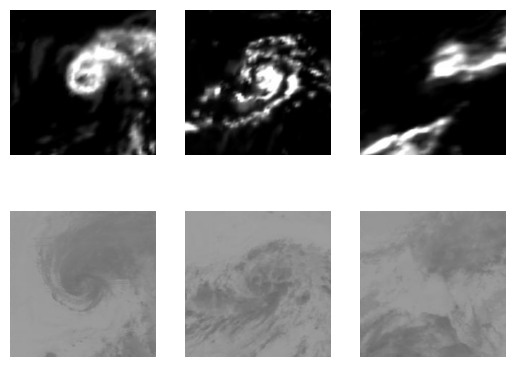

In [2]:
from numpy import load
from matplotlib import pyplot

# Load the dataset
data = load('pmwtoir_256.npz')
# Split the data into two arrays
dataA, dataB = data['arr_0'], data['arr_1']
# Print the shapes of the loaded arrays
print('Loaded: ', dataA.shape, dataB.shape)

# Define the number of samples to plot
n_samples = 3

# Plot source images
for i in range(n_samples):
    # Create a subplot for each sample
    pyplot.subplot(2, n_samples, 1 + i)
    # Turn off the axis
    pyplot.axis('off')
    # Display the image in grayscale
    pyplot.imshow(dataA[i].astype('uint8'), cmap='gray')

# Plot target images
for i in range(n_samples):
    # Create a subplot for each sample
    pyplot.subplot(2, n_samples, 1 + n_samples + i)
    # Turn off the axis
    pyplot.axis('off')
    # Display the image in grayscale
    pyplot.imshow(dataB[i].astype('uint8'), cmap='gray')

# Show the plotted images
pyplot.show()

# Install and Import packages for Training Cycle GAN

In [3]:
# Install Keras contrib package for Instance Normalization
!pip install git+https://www.github.com/keras-team/keras-contrib.git


  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-wm1sq5yl
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-wm1sq5yl
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras_contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101060 sha256=37a366e5c67c87aa5f70267c4cd85be282822a171a859d14548d1ce7f8cb0001
  Stored in directory: /tmp/pip-ephem-wheel-cache-ryi1q9ya/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras_contrib


In [4]:
# Importing required packages

from random import random
from numpy import load
from numpy import zeros
from numpy import ones
from numpy import asarray
from numpy.random import randint
from keras.optimizers import Adam
from keras.initializers import RandomNormal
from keras.models import Model
from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Activation
from keras.layers import Concatenate
from keras.utils import plot_model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from matplotlib import pyplot

# Define Discriminator Model

This Python function defines a discriminator model for a CycleGAN. The discriminator is a convolutional neural network that classifies images as real or fake. It's trained to maximize the probability of assigning the correct label to both training examples and samples from the generator.

In [5]:
def define_discriminator(image_shape):
    # Initialize weights with a normal distribution of mean=0 and standard deviation=0.02
    init = RandomNormal(stddev=0.02)
    
    # Define the input layer that takes an image of shape 'image_shape'
    in_image = Input(shape=image_shape)
    
    # Define a convolutional layer with 64 filters, kernel size of 4x4, stride of 2x2, same padding and the defined weight initialization
    d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
    d = LeakyReLU(alpha=0.2)(d)  # Apply leaky ReLU activation with alpha=0.2
    
    # Repeat the above steps with 128, 256, and 512 filters, adding instance normalization after each convolution
    for filters in [128, 256, 512]:
        d = Conv2D(filters, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
        d = InstanceNormalization(axis=-1)(d)  # Normalize the activations of the previous layer at each step, i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1.
        d = LeakyReLU(alpha=0.2)(d) # Apply LeakyReLU activation function with a negative slope coefficient of 0.2
    
    # Define a second last convolutional layer with 512 filters
    d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
    d = InstanceNormalization(axis=-1)(d)
    
	# Apply LeakyReLU activation function with a negative slope coefficient of 0.2
    d = LeakyReLU(alpha=0.2)(d)
    
    # Define the output layer that outputs a patch of 1 channel
    patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
    
    # Define the model with the specified input and output layers
    model = Model(in_image, patch_out)
    
    # Compile the model with mean squared error loss, Adam optimizer with learning rate=0.0002 and beta_1=0.5, and a loss weight of 0.5
    model.compile(loss='mse', optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss_weights=[0.5])
    
    return model  # Return the compiled model

# Define Residual Block

This function defines a ResNet block, which is a fundamental building block of ResNet (Residual Network). It consists of two convolutional layers with the same number of filters, kernel size, and padding. After each convolution, instance normalization is applied. The output of the second convolutional layer is then concatenated with the input to the block, forming a "shortcut connection" that allows the model to learn an identity function and mitigates the problem of vanishing gradients in deep networks.

In [6]:
# Define a ResNet block
def resnet_block(n_filters, input_layer):
    # Initialize weights with a normal distribution of mean=0 and standard deviation=0.02
    init = RandomNormal(stddev=0.02)
    
    # Define the first convolutional layer with 'n_filters' filters, a 3x3 kernel size, same padding, and the defined weight initialization
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(input_layer)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Define the second convolutional layer similar to the first
    g = Conv2D(n_filters, (3,3), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    
    # Concatenate the output of the second convolutional layer with the input layer along the channel axis
    g = Concatenate()([g, input_layer])
    
    return g  # Return the output of the ResNet block

# Define Generator Model

This function defines a generator model for a CycleGAN. The generator is a convolutional neural network that transforms an input image into an output image. It consists of a series of ResNet blocks, followed by a series of upsampling layers. The generator is trained to minimize the difference between the output image and the target image, as well as to fool the discriminator into classifying the generated image as real.

In [7]:
# Define the standalone generator model
def define_generator(image_shape, n_resnet=9):
    # Initialize weights with a normal distribution of mean=0 and standard deviation=0.02
    init = RandomNormal(stddev=0.02)
    
    # Define the input layer that takes an image of shape 'image_shape'
    in_image = Input(shape=image_shape)
    
    # Define a convolutional layer with 64 filters, a 7x7 kernel size, same padding, and the defined weight initialization
    g = Conv2D(64, (7,7), padding='same', kernel_initializer=init)(in_image)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Define a convolutional layer with 128 filters, a 3x3 kernel size, a stride of 2x2, same padding, and the defined weight initialization
    g = Conv2D(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Define a convolutional layer with 256 filters, a 3x3 kernel size, a stride of 2x2, same padding, and the defined weight initialization
    g = Conv2D(256, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Add 'n_resnet' number of ResNet blocks, each with 256 filters
    for _ in range(n_resnet):
        g = resnet_block(256, g)
    
    # Define a transposed convolutional layer (also called a deconvolutional layer) with 128 filters, a 3x3 kernel size, a stride of 2x2, same padding, and the defined weight initialization
    g = Conv2DTranspose(128, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Define another transposed convolutional layer with 64 filters
    g = Conv2DTranspose(64, (3,3), strides=(2,2), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    g = Activation('relu')(g)  # Apply ReLU activation function
    
    # Define a convolutional layer with 3 filters (for the RGB channels of the output image), a 7x7 kernel size, same padding, and the defined weight initialization
    g = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(g)
    g = InstanceNormalization(axis=-1)(g)  # Normalize the activations of the previous layer at each step
    out_image = Activation('tanh')(g)  # Apply tanh activation function to the output to scale it to the range [-1, 1]
    
    # Define the model with the specified input and output layers
    model = Model(in_image, out_image)
    
    return model  # Return the defined model

# Define Composite Model

The composite model is used to update the generators based on both adversarial and cycle loss. It consists of two generator models and a discriminator model. The generators are trained to transform images from one domain to another and back, while the discriminator is trained to distinguish real images from generated ones. The model is compiled with a combination of mean squared error (for the adversarial loss) and mean absolute error (for the cycle and identity losses).

In [8]:
# Define a composite model for updating generators by adversarial and cycle loss
def define_composite_model(g_model_1, d_model, g_model_2, image_shape):
    # Ensure the model we're updating is trainable
    g_model_1.trainable = True
    
    # Mark discriminator as not trainable
    d_model.trainable = False
    
    # Mark other generator model as not trainable
    g_model_2.trainable = False
    
    # Discriminator element
    input_gen = Input(shape=image_shape)  # Define the input layer that takes an image of shape 'image_shape'
    gen1_out = g_model_1(input_gen)  # Pass the input through the first generator model
    output_d = d_model(gen1_out)  # Pass the output of the first generator through the discriminator model
    
    # Identity element
    input_id = Input(shape=image_shape)  # Define another input layer for the identity mapping
    output_id = g_model_1(input_id)  # Pass this input through the first generator model
    
    # Forward cycle
    output_f = g_model_2(gen1_out)  # Pass the output of the first generator through the second generator model
    
    # Backward cycle
    gen2_out = g_model_2(input_id)  # Pass the identity input through the second generator model
    output_b = g_model_1(gen2_out)  # Pass the output of the second generator through the first generator model
    
    # Define model graph
    model = Model([input_gen, input_id], [output_d, output_id, output_f, output_b])  # Define the model with the specified inputs and outputs
    
    # Define optimization algorithm configuration
    opt = Adam(lr=0.0002, beta_1=0.5)  # Use the Adam optimizer with a learning rate of 0.0002 and a beta_1 value of 0.5
    
    # Compile model with weighting of least squares loss and L1 loss
    model.compile(loss=['mse', 'mae', 'mae', 'mae'], loss_weights=[1, 5, 10, 10], optimizer=opt)  # Compile the model with mean squared error and mean absolute error losses, and the defined optimizer
    
    return model  # Return the defined model

# Load and prepare training images

This function loads a dataset of images from a file, unpacks the images into two separate arrays, scales the pixel values of the images from the range [0, 255] (standard for RGB images) to the range [-1, 1] (commonly used range for neural network inputs), and returns the two arrays of scaled images.

In [9]:
def load_real_samples(filename):
    # Load the dataset from the provided filename
    data = load(filename)
    
    # Unpack arrays from the loaded data
    # 'arr_0' and 'arr_1' are the default keys used by numpy's savez function to store arrays
    X1, X2 = data['arr_0'], data['arr_1']
    
    # Scale the images from [0,255] to [-1,1]
    # This is a common preprocessing step for neural network inputs
    # It helps to normalize the input values and make the training process more stable
    X1 = (X1 - 127.5) / 127.5
    X2 = (X2 - 127.5) / 127.5
    
    # Return the scaled images as a list
    return [X1, X2]

# Generate Real Samples

This function selects a batch of random samples from a dataset of images, generates 'real' class labels (1) for these samples, and returns the samples and their labels. The function is used to prepare inputs and targets for training the discriminator model on real images.

In [10]:
def generate_real_samples(dataset, n_samples, patch_shape):
    # Choose random instances from the dataset
    # The randint function generates 'n_samples' random integers between 0 and the number of samples in the dataset
    ix = randint(0, dataset.shape[0], n_samples)
    
    # Retrieve selected images from the dataset using the generated indices
    X = dataset[ix]
    
    # Generate 'real' class labels (1) for the selected images
    # The ones function generates an array of ones with the specified shape
    # In this case, the shape is (n_samples, patch_shape, patch_shape, 1), which corresponds to the output shape of the discriminator model
    y = ones((n_samples, patch_shape, patch_shape, 1))
    
    # Return the selected images and their corresponding 'real' class labels
    return X, y

# Generate Fake Samples

This function generates a batch of fake samples using a generator model, generates 'fake' class labels (0) for these samples, and returns the samples and their labels. The function is used to prepare inputs and targets for training the discriminator model on fake images.

In [11]:
def generate_fake_samples(g_model, dataset, patch_shape):
    # Generate fake instances using the generator model
    # The predict function generates outputs (in this case, fake images) given inputs (in this case, the dataset)
    X = g_model.predict(dataset)
    
    # Create 'fake' class labels (0) for the generated images
    # The zeros function generates an array of zeros with the specified shape
    # In this case, the shape is (len(X), patch_shape, patch_shape, 1), which corresponds to the output shape of the discriminator model
    y = zeros((len(X), patch_shape, patch_shape, 1))
    
    # Return the generated images and their corresponding 'fake' class labels
    return X, y

# Saving the Generator Models

This function saves the current state of the two generator models to disk. The models are saved in the Keras file format, which is a common format for storing large amounts of numerical data (a successor to the legacy HD5 format).

In [12]:
def save_models(step, g_model_AtoB, g_model_BtoA):
    # Create a directory named 'models' if it doesn't exist
    # This is where the models will be saved
    if not os.path.exists('models'):
        os.makedirs('models')

    # Save the first generator model (A to B)
    # The filename includes the current step number (plus one), formatted as a six-digit number
    filename1 = 'models/g_model_AtoB_%d.keras' % (step+1)
    g_model_AtoB.save(filename1)

    # Save the second generator model (B to A)
    # The filename includes the current step number (plus one), formatted as a six-digit number
    filename2 = 'models/g_model_BtoA_%d.keras' % (step+1)
    g_model_BtoA.save(filename2)

    # Print a message indicating that the models have been saved
    print('> Saved: %s and %s' % (filename1, filename2))

# Generate Sample and Save Results

This function generates a batch of images using the generator model, plots these images along with their corresponding real images from the training set, and saves the plot to a file. The function is used to periodically visualize the performance of the generator model during training.

In [13]:
def summarize_performance(step, g_model, trainX, name, n_samples=5):
    # Select a sample of input images from the training set
    X_in, _ = generate_real_samples(trainX, n_samples, 0)
    
    # Generate translated images from the input images using the generator model
    X_out, _ = generate_fake_samples(g_model, X_in, 0)
    
    # Scale all pixels from the range [-1,1] (used for model input) to the range [0,1] (used for displaying images)
    X_in = (X_in + 1) / 2.0
    X_out = (X_out + 1) / 2.0
    
    # Plot the real input images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + i)  # Create a subplot for each image
        pyplot.axis('off')  # Hide the axis
        pyplot.imshow(X_in[i])  # Display the image
    
    # Plot the translated (generated) images
    for i in range(n_samples):
        pyplot.subplot(2, n_samples, 1 + n_samples + i)  # Create a subplot for each image
        pyplot.axis('off')  # Hide the axis
        pyplot.imshow(X_out[i])  # Display the image
    
    # Save the plot to file
    # Create a directory named 'images' if it doesn't exist
    if not os.path.exists('images'):
        os.makedirs('images')
    # Define the filename for the plot
    filename1 = 'images/%s_generated_plot_%06d.png' % (name, (step+1))
    # Save the plot as a PNG file
    pyplot.savefig(filename1)
    # Close the plot to free up memory
    pyplot.close()

# Update Image Pool for Fake Images

This function updates the pool of fake images used to train the discriminator model. The pool is used to reduce overfitting by providing a more diverse set of fake images for training.

In [14]:
def update_image_pool(pool, images, max_size=50):
    # Initialize a list to hold the selected images
    selected = list()
    
    # Iterate over each image in the input list of images
    for image in images:
        # If the pool is not yet full
        if len(pool) < max_size:
            # Add the image to the pool
            pool.append(image)
            # Also add the image to the list of selected images
            selected.append(image)
        # If the pool is full and a random number is less than 0.5
        elif random() < 0.5:
            # Use the image (add it to the list of selected images), but don't add it to the pool
            selected.append(image)
        else:
            # If the pool is full and a random number is greater than or equal to 0.5
            # Replace an existing image in the pool with the new image
            ix = randint(0, len(pool))
            # Add the replaced image to the list of selected images
            selected.append(pool[ix])
            # Replace the selected image in the pool with the new image
            pool[ix] = image
    
    # Return the list of selected images as a numpy array
    return asarray(selected)

# Train the Cycle GAN Model

This function trains a Cycle GAN model on a dataset of tropical cyclone images. It consists of two main training loops: one for training the discriminator models and one for training the generator models.

The training process involves updating the weights of the models based on the loss calculated from the difference between real and fake images, as well as the difference between original and reconstructed images.

Loaded (2000, 256, 256, 3) (2000, 256, 256, 3)


/opt/conda/lib/python3.10/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


C Model A to B Summary
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 3)          3527655   ['input_5[0][0]',             
                                                          3          'input_6[0][0]',             
                                                                     'model_1[1][0]']             
                                                                                                  
 input_6 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                     

I0000 00:00:1709701264.982912     111 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


>1, dA[1.153,0.893] dB[1.708,2.261] g[23.925,25.183]
1/1 [==============================] - 0s 25ms/step
>2, dA[17.988,1.180] dB[1.961,4.781] g[20.468,25.654]
1/1 [==============================] - 0s 24ms/step
>3, dA[4.177,1.008] dB[5.602,19.069] g[45.187,21.514]
1/1 [==============================] - 0s 24ms/step
>4, dA[3.226,1.001] dB[5.047,7.560] g[19.797,20.633]
1/1 [==============================] - 0s 25ms/step
>5, dA[1.042,1.192] dB[3.300,7.287] g[19.468,20.539]
1/1 [==============================] - 0s 23ms/step
>6, dA[2.483,1.213] dB[1.349,2.555] g[13.307,17.969]
1/1 [==============================] - 0s 24ms/step
>7, dA[3.964,1.051] dB[0.529,0.662] g[13.911,18.315]
1/1 [==============================] - 0s 23ms/step
>8, dA[2.620,1.068] dB[0.704,0.496] g[13.212,17.339]
1/1 [==============================] - 0s 22ms/step
>9, dA[0.904,0.666] dB[0.436,0.436] g[12.242,15.629]
1/1 [==============================] - 0s 22ms/step
>10, dA[0.603,0.778] dB[0.343,0.574] g[11.646,16.050]

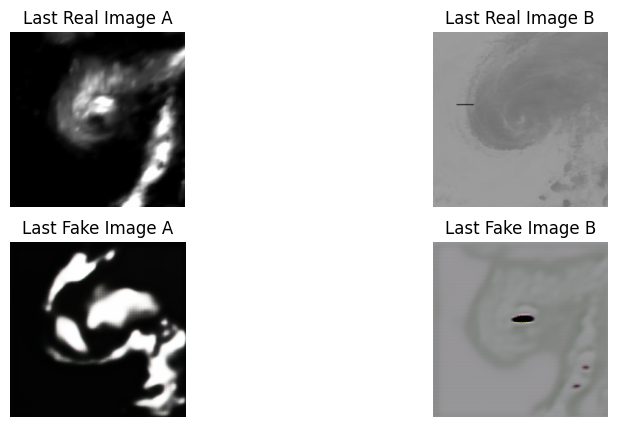

In [15]:
import matplotlib.pyplot as plt
def train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset):
    # Split the dataset into two parts
    trainA, trainB = dataset
    
    # Define the number of epochs and batch size
    n_epochs, n_batch, = 1,1
    
    # Determine the output square shape of the discriminator
    n_patch = d_model_A.output_shape[1]
    
    # Prepare image pool for fakes
    poolA, poolB = list(), list()
    
    # Calculate the number of batches per training epoch
    bat_per_epo = int(len(trainA) / n_batch)
    
    # Calculate the number of training iterations
    n_steps = bat_per_epo * n_epochs
    
    # Initialize lists to store all real and fake images
    all_realA, all_realB, all_fakeA, all_fakeB = [], [], [], []
    
    # Print the training parameters
    print('n_epochs=%d, n_batch=%d, 1/2=%d, b/e=%d, steps=%d' % (n_epochs, n_batch, n_batch/2, bat_per_epo, n_steps))
    
    # Manually enumerate epochs
    for i in range(n_steps):
        # Select a batch of real samples
        X_realA, y_realA = generate_real_samples(trainA, n_batch, n_patch)
        X_realB, y_realB = generate_real_samples(trainB, n_batch, n_patch)
        
        # Generate a batch of fake samples
        X_fakeA, y_fakeA = generate_fake_samples(g_model_BtoA, X_realB, n_patch)
        X_fakeB, y_fakeB = generate_fake_samples(g_model_AtoB, X_realA, n_patch)
        
        # Update fakes from pool
        X_fakeA = update_image_pool(poolA, X_fakeA)
        X_fakeB = update_image_pool(poolB, X_fakeB)
        
        # Append the images of the current batch to the lists
        all_realA.append(X_realA)
        all_realB.append(X_realB)
        all_fakeA.append(X_fakeA)
        all_fakeB.append(X_fakeB)
        
        # Update generator B->A via adversarial and cycle loss
        g_loss2, _, _, _, _  = c_model_BtoA.train_on_batch([X_realB, X_realA], [y_realA, X_realA, X_realB, X_realA])
        
        # Update discriminator for A -> [real/fake]
        dA_loss1 = d_model_A.train_on_batch(X_realA, y_realA)
        dA_loss2 = d_model_A.train_on_batch(X_fakeA, y_fakeA)
        
        # Update generator A->B via adversarial and cycle loss
        g_loss1, _, _, _, _ = c_model_AtoB.train_on_batch([X_realA, X_realB], [y_realB, X_realB, X_realA, X_realB])
        
        # Update discriminator for B -> [real/fake]
        dB_loss1 = d_model_B.train_on_batch(X_realB, y_realB)
        dB_loss2 = d_model_B.train_on_batch(X_fakeB, y_fakeB)
        
        # Summarize performance
        print('>%d, dA[%.3f,%.3f] dB[%.3f,%.3f] g[%.3f,%.3f]' % (i+1, dA_loss1,dA_loss2, dB_loss1,dB_loss2, g_loss1,g_loss2))
        
    # Evaluate the model performance every so often
    # Plot A->B translation
    summarize_performance(i, g_model_AtoB, trainA, 'AtoB')
    # Plot B->A translation
    summarize_performance(i, g_model_BtoA, trainB, 'BtoA')
    
    # Save the models
    save_models(i, g_model_AtoB, g_model_BtoA)

    # Convert the lists to numpy arrays
    all_realA = np.concatenate(all_realA)
    all_realB = np.concatenate(all_realB)
    all_fakeA = np.concatenate(all_fakeA)
    all_fakeB = np.concatenate(all_fakeB)
    
    # Create a new figure
    plt.figure(figsize=(10,5))

    # Plot the last real image from A and B
    plt.subplot(2, 2, 1) # 2 rows, 2 columns, 1st subplot = top left
    plt.title('Last Real Image A')
    plt.imshow((all_realA[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    plt.subplot(2, 2, 2) # 2 rows, 2 columns, 2nd subplot = top right
    plt.title('Last Real Image B')
    plt.imshow((all_realB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Plot the last fake image from A and B
    plt.subplot(2, 2, 3) # 2 rows, 2 columns, 3rd subplot = bottom left
    plt.title('Last Fake Image A')
    plt.imshow((all_fakeA[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    plt.subplot(2, 2, 4) # 2 rows, 2 columns, 4th subplot = bottom right
    plt.title('Last Fake Image B')
    plt.imshow((all_fakeB[-1] * 0.5) + 0.5) # Scale the image pixels back to the range [0,1]
    plt.axis('off')

    # Show the figure with the images
    plt.show()

# Load image data
dataset = load_real_samples('pmwtoir_256.npz')
print('Loaded', dataset[0].shape, dataset[1].shape)

# Define input shape based on the loaded dataset
image_shape = dataset[0].shape[1:]
# Define generator: A -> B
g_model_AtoB = define_generator(image_shape)
# Define generator: B -> A
g_model_BtoA = define_generator(image_shape)
# Define discriminator: A -> [real/fake]
d_model_A = define_discriminator(image_shape)
# Define discriminator: B -> [real/fake]
d_model_B = define_discriminator(image_shape)
# Define composite model: A -> B -> [real/fake, A]
c_model_AtoB = define_composite_model(g_model_AtoB, d_model_B, g_model_BtoA, image_shape)
# Define composite model: B -> A -> [real/fake, B]
c_model_BtoA = define_composite_model(g_model_BtoA, d_model_A, g_model_AtoB, image_shape)

# Summarize the model
print('C Model A to B Summary')
c_model_AtoB.summary()
print('C Model B to A Summary')
c_model_BtoA.summary()
    
# Plot the model
plot_model(c_model_AtoB, to_file='c-model-AtoB-plot.png', show_shapes=True, show_layer_names=True)
plot_model(c_model_BtoA, to_file='c-model-BtoA-plot.png', show_shapes=True, show_layer_names=True)

# Train models
train(d_model_A, d_model_B, g_model_AtoB, g_model_BtoA, c_model_AtoB, c_model_BtoA, dataset)

# Testing CycleGAN

This section tests the CycleGAN model on a set of test images. It generates images using the generator model and saves the results to a file for later visualization.

In [16]:
# Import packages
import cv2
import os
import numpy as np
from numpy import asarray
from numpy import vstack
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from numpy import savez_compressed

# Dataset directory path
directory = r'/kaggle/input/tcirrp-dataset/TCIRRP/test1k'

# Get a list of all the file paths
image_paths = [os.path.join(directory, img) for img in os.listdir(directory)]

# Load the images in grayscale
images = np.array([cv2.imread(img_path) for img_path in image_paths])

pmw=[]
ir=[]

# cv2.imshow('image',images[0])
for i in range(len(images)):
    image1 = images[i][0:201, 0:201]
    image2 = images[i][0:201,201:402]
    #print(image1.shape)
    image1=cv2.resize(image1,(256,256))
    image2=cv2.resize(image2,(256,256))
    #print(image1.shape)
    image1=image1.reshape(256,256,3)
    image2=image2.reshape(256,256,3)
    pmw.append(image1)
    ir.append(image2)
pmw=np.array(pmw)
ir=np.array(ir)
print(ir.shape)
# Now `images` is a list of numpy arrays representing your images in grayscale

(1001, 256, 256, 3)


# Load model for Testing

This block loads two pre-trained models: model_BtoA and model_AtoB. These models are used to transform images from one domain to another in a CycleGAN. The InstanceNormalization layer is a custom layer used in these models, so it needs to be passed to the load_model function via the custom_objects parameter.

In [17]:
# Import necessary libraries
from keras.models import load_model
from numpy import load

# Load the model that transforms images from domain A to domain B
# The custom_objects parameter is used to map the name of the custom layer (InstanceNormalization) to the actual class
model_AtoB = load_model('models/g_model_AtoB_2000.keras', custom_objects={'InstanceNormalization': InstanceNormalization})

# Load the model that transforms images from domain B to domain A
# The custom_objects parameter is used to map the name of the custom layer (InstanceNormalization) to the actual class
model_BtoA = load_model('models/g_model_BtoA_2000.keras', custom_objects={'InstanceNormalization': InstanceNormalization})

# Select Sample Images

This block selects a random image from domain B, uses the BtoA model to generate a corresponding image in domain A, and then uses the AtoB model to reconstruct the original image in domain B. The shapes of the images and the actual image data are then printed.

In [18]:
from numpy.random import randint
import numpy as np

def select_sample(dataset, n_samples):
    # Choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # Retrieve selected images
    X = dataset[ix]
    return X

# Initialize lists for storing generated and reconstructed images
B_generated = []
A_reconstructed = []

# Select a random image from domain B
A_real = ir

for i in A_real:
    # Reshape the image
    i = i.reshape(1, 256, 256, 3)

    # Use the BtoA model to generate an image in domain A
    s = model_BtoA.predict(i)
    B_generated.append(s)

    # Use the AtoB model to reconstruct the original image in domain B
    A_reconstructed.append(model_AtoB.predict(s))

# Convert the lists to numpy arrays
A_real = np.array(A_real)
B_generated = np.array(B_generated)
A_reconstructed = np.array(A_reconstructed)

# Print the shapes of the images
print(A_real.shape, B_generated.shape, A_reconstructed.shape)

1/1 [==============================] - 0s 25ms/step
(1001, 256, 256, 3) (1001, 1, 256, 256, 3) (1001, 1, 256, 256, 3)


In [19]:
gen=[]
recon=[]
rel=[]
# print(A_real[0],B_generated[0],A_reconstructed[0])
B_generated= B_generated.reshape(1001, 256, 256, 3)
A_reconstructed=A_reconstructed.reshape(1001,256,256,3)
for i in range(len(B_generated)):
    k=(B_generated[i]+1)/2
    k1=(A_real[i])/255
    k2=(A_reconstructed[i]+1)/2
    gen.append(k)
    recon.append(k2)
    rel.append(k1)
B_generated=np.array(gen)
A_reconstructed=np.array(recon)
A_real=np.array(rel)
print(A_real.shape, B_generated.shape, A_reconstructed.shape)
# print(A_real[0],B_generated[0],A_reconstructed[0])


(1001, 256, 256, 3) (1001, 256, 256, 3) (1001, 256, 256, 3)


# Explore Performance Metrics

1. **Peak Signal-to-Noise Ratio** (PSNR), is the ratio of the energy of the peak signal to the average energy of noise.
2. **Root Mean Square Error** (RMSE), can assess the difference between the forecast and actual values.
3. **Pearson Correlation Coefficient** (CC) can describe the level of linear correlation between Passive Microwave Rainfall (PMR) images’ estimate and the actual value.
4. **Structural SIMilarity** (SSIM) of luminance, contrast, and structure can be evaluated to quantitatively describe the performance of the proposed model.

In [20]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr
from IPython.display import display, HTML
import numpy as np
import pandas as pd

def calculate_rmse(target, prediction):
    # Calculate Root Mean Square Error (RMSE) between target and prediction
    return np.sqrt(((prediction - target) ** 2).mean())

def calculate_psnr(target, prediction):
    # Calculate Peak Signal-to-Noise Ratio (PSNR) between target and prediction
    return psnr(target, prediction, data_range=prediction.max() - prediction.min())

def calculate_cc(target, prediction):
    # Calculate Pearson Correlation Coefficient (CC) between target and prediction
    return pearsonr(target.flatten(), prediction.flatten())[0]

def calculate_ssim(target, prediction):
    # Calculate Structural Similarity Index Measure (SSIM) between target and prediction
    return ssim(target, prediction, win_size=3, multichannel=True, data_range=prediction.max() - prediction.min())

# Reshape the predicted images
prediction = B_generated
target=A_real
# Initialize metrics
rmse, psnrv, cc, ssimv = 0, 0, 0, 0

# Calculate metrics for each image in the dataset
n = len(target)
for i in range(n):
    rmse += calculate_rmse(target[i], prediction[i])
    psnrv += calculate_psnr(target[i], prediction[i])
    cc += calculate_cc(target[i], prediction[i])
    ssimv += calculate_ssim(target[i], prediction[i])

# Calculate average metrics
rmse /= n
psnrv /= n
cc /= n
ssimv /= n

# Create a DataFrame to display the results
df = pd.DataFrame({
    'Metric': ['RMSE', 'PSNR', 'CC', 'SSIM'],
    'Value': [rmse*255, psnrv, cc, ssimv]
})

# Convert the DataFrame to HTML
df_html = df.to_html()

# Display the HTML
display(HTML(df_html))

,Metric,Value
0,RMSE,123.958976
1,PSNR,6.229275
2,CC,-0.178348
3,SSIM,0.158928


# Convert Images to Grayscale and Reshape

This code converts the generated and reconstructed images to grayscale and reshapes them to have a single channel. The shapes of the images are then printed.

In [21]:
# Print the shapes of the images
B_generated=B_generated.reshape(len(B_generated),256,256,3)
A_reconstructed=A_reconstructed.reshape(len(A_reconstructed),256,256,3)
print(A_real.shape, B_generated.shape, A_reconstructed.shape)

(1001, 256, 256, 3) (1001, 256, 256, 3) (1001, 256, 256, 3)


# Visualize Generated and Reconstructed Images

This function takes the input as the real image, the generated image, and the reconstructed image. It first scales the images from the range [-1,1] to the range [0,1]. It then plots the real image, followed by the generated and reconstructed images. The images are displayed in grayscale.

In [22]:
def show_plot(imagesX, imagesY1, imagesY2):
    # Stack the generated and reconstructed images vertically
    images = vstack((imagesY1, imagesY2))
    # Define the titles for the subplots
    titles = ['Generated', 'Reconstructed']
    
    # Scale the real and generated images from [-1,1] to [0,1]
    imagesX = (imagesX[0] + 1) / 2.0
    images = (images + 1) / 2.0
    
    # Plot the real image
    pyplot.subplot(1, len(images), 1 + 0)
    pyplot.axis('off')
    pyplot.imshow(imagesX)
    pyplot.title("Real")
    
    # Plot the generated and reconstructed images
    for i in range(len(images)):
        # Define subplot
        pyplot.subplot(1, len(images), 1 + i+1)
        # Turn off axis
        pyplot.axis('off')
        # Plot raw pixel data
        pyplot.imshow(images[i], cmap='gray')
        # Title
        pyplot.title(titles[i])
    
    # Display the plot
    pyplot.show()

# Plotting Images

In [23]:
# Import necessary libraries
import cv2
from numpy import asarray
from numpy import vstack

# Print the shape of the generated image
print(A_reconstructed.shape)

# Print the actual data of the real image
# print(A_real[0])

(1001, 256, 256, 3)


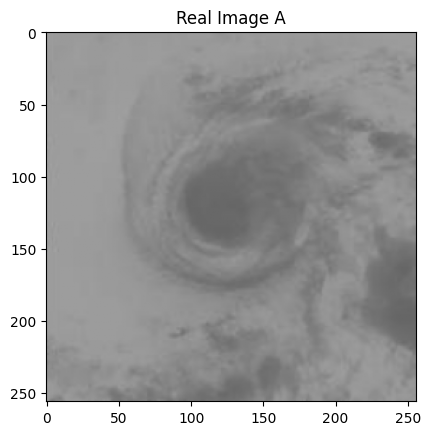

In [24]:
import matplotlib.pyplot as plt

# Display the real image
plt.title('Real Image A')
plt.imshow(A_real[0])
plt.show()

(256, 256, 3)


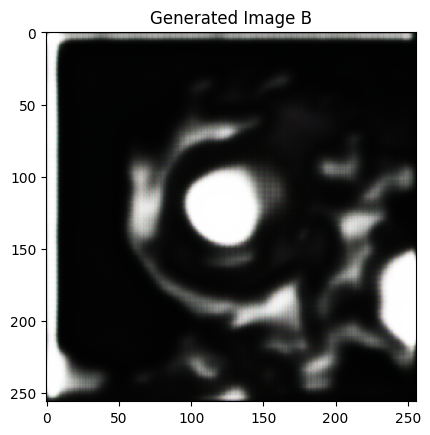

In [25]:
import matplotlib.pyplot as plt
# Display the generated image in grayscale
plt.imshow(B_generated[0])

# Print the shape of the generated image
plt.title('Generated Image B')
print(B_generated[0].shape)
# print(B_generated[0])

(256, 256, 3)
[[[0.585624   0.59615195 0.59207207]
  [0.58441144 0.59820086 0.5871102 ]
  [0.58874357 0.6061912  0.5868226 ]
  ...
  [0.5873928  0.59248924 0.59806365]
  [0.5912968  0.59628433 0.58952075]
  [0.58732456 0.5831763  0.585685  ]]

 [[0.5859046  0.5857731  0.5877655 ]
  [0.5891613  0.5881725  0.590588  ]
  [0.5837958  0.5857301  0.5855792 ]
  ...
  [0.5972602  0.5922042  0.60026276]
  [0.58952683 0.5971139  0.59408313]
  [0.5898107  0.5923082  0.5835032 ]]

 [[0.58695364 0.59899527 0.59426934]
  [0.59425557 0.6047322  0.5960372 ]
  [0.5994094  0.61152595 0.59433186]
  ...
  [0.5957919  0.59281147 0.60462415]
  [0.58869326 0.590922   0.5919023 ]
  [0.5905265  0.5797094  0.58787197]]

 ...

 [[0.57563686 0.58459234 0.5785357 ]
  [0.5764636  0.5870799  0.5836346 ]
  [0.5736675  0.5799443  0.58149844]
  ...
  [0.5681522  0.5742519  0.57988286]
  [0.5689847  0.5652094  0.5701366 ]
  [0.5635791  0.5720429  0.5729873 ]]

 [[0.58080274 0.58142513 0.5848749 ]
  [0.57588017 0.5805967

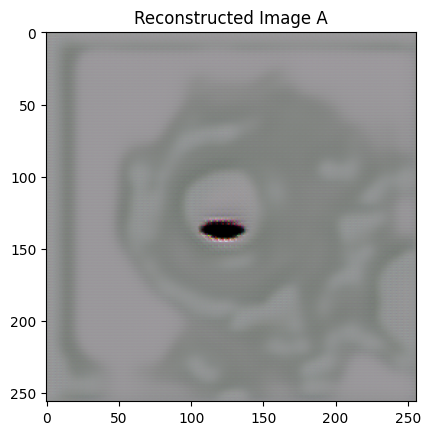

In [26]:
# Display the reconstructed image in grayscale
plt.imshow(A_reconstructed[0])

# Print the shape of the reconstructed image
plt.title('Reconstructed Image A')
print(A_reconstructed[0].shape)
print(A_reconstructed[0])

# Observation/Conclusion

CycleGAN effectively performs image-to-image translation without paired data, as demonstrated in this notebook. The model successfully transformed, generated, and reconstructed images. However, the quality of results can be improved by increasing the training set for model's training and complexity of transformations.